In [4]:
import numpy as np
import random as random
import matplotlib.pyplot as plt
import time
import pandas as pd
import multiprocessing
import itertools
from scipy.spatial import distance
from matplotlib import animation

PATH = '../StudyGroup/'

# Alex's work 

Changed it all to pandas (removed A and I for one DataFrame called InfectedFarms) as I work better with a table, ignore if you prefer matrices

In [5]:
#Import Data
farmData = pd.read_csv(PATH +'Farms_2010_RSG', sep = '\s+', header = None, names = ['County Number', 'Parish Number', 'Holding Number',
                                                                              'X Coordinate', 'Y Coordinate', 'Number of Cattle', 
                                                                              'Number of Sheep'])
cumbData = farmData[farmData['County Number'] == 8]
cumbData = cumbData.reset_index(drop=True)
xCumb = cumbData['X Coordinate']/100000
yCumb = cumbData['Y Coordinate']/100000
xmax = np.max(xCumb)
xmin = np.min(xCumb)
ymax = np.max(yCumb)
ymin = np.min(yCumb)
sizex = xmax-xmin
sizey = ymax-ymin
cattleFrame = cumbData['Number of Cattle']
sheepFrame = cumbData['Number of Sheep']
xcoord = xCumb - xmin #Shift to start from (0, 0)
ycoord = yCumb - ymin #Shift to start from (0, 0)
N=np.size(xcoord)

In [6]:
#Calculate Euclidean distances
xinput = xcoord.values
yinput = ycoord.values
joinedinput = np.column_stack((xinput, yinput))
dist = distance.cdist(joinedinput, joinedinput, 'euclidean')

In [7]:
#Parameter values
        
psi = 0.00657
nu = 1.99*(10**(-7))
xi = 2.65
zeta = 1.80
chi = 0.403
s = np.random.negative_binomial(50, 50/55, N) #Draw latent periods
r = np.random.negative_binomial(30, 30/39, N) #Draw infectious periods

t = 0
A = np.zeros(shape=(N,4))
output = np.zeros(shape=(N,6))
mycolumns = ['Farm Number', 'Status', 'Time of Exposure', 'Time of Culling',
                                       'Latent Period', 'Infectious Period', 'X coordinate', 'Y coordinate']
InfectedFarms  = pd.DataFrame(columns =mycolumns)

In [8]:
np.mean(r)

9.044930875576037

In [9]:
InfectedFarms['Farm Number']= cumbData.index                                                                                               
InfectedFarms['Status' ] = np.zeros(N)
InfectedFarms['Latent Period'] = s
InfectedFarms['Infectious Period'] = r
InfectedFarms['X coordinate'] = xinput
InfectedFarms['Y coordinate'] = yinput
InfectedFarms[['Time of Exposure', 'Time of Culling']]=[-100,-100]

In [10]:
#Calculate distance kernel
cattle = abs(cattleFrame.values)
sheep = abs(sheepFrame.values)
K = psi/(psi**2 + dist**2)

K[np.where(dist > 0.2)] = 0

beta1 = np.zeros(N)
beta1 = nu*(xi*(cattle)**chi + (sheep)**chi)

In [11]:
#Choose initial case

initial1 = random.randint(0,N)
initial2=initial1+1
initial3=initial2+1
initial4=initial3+1

In [12]:
InfectedFarms.loc[initial1,['Status', 'Time of Exposure']] =[1,t]
InfectedFarms.loc[initial2,['Status', 'Time of Exposure']] =[1,t]
InfectedFarms.loc[initial3,['Status', 'Time of Exposure']] =[1,t]
InfectedFarms.loc[initial4,['Status', 'Time of Exposure']] =[1,t]

Text(0.5,1,'Map of the initial farms infected')

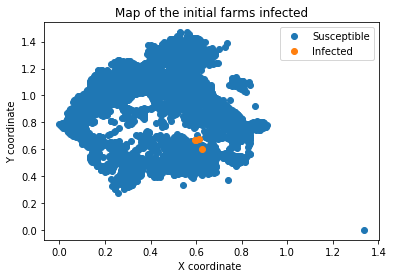

In [13]:
plt.plot(InfectedFarms['X coordinate'], InfectedFarms['Y coordinate'], 'o',label = 'Susceptible')
plt.plot(InfectedFarms[InfectedFarms['Status']==1]['X coordinate'], InfectedFarms[InfectedFarms['Status']==1]['Y coordinate'], 'o', label = 'Infected')
plt.legend(loc = 'upper right')
plt.xlabel('X coordinate ')
plt.ylabel('Y coordinate')
plt.title('Map of the initial farms infected')

In [14]:
start_time = time.time()
IP = InfectedFarms['Status']
T = 0
while sum(IP == 1) + sum(IP == 2) > 0:
    T = T+1
#     print("Day", T, "Exposed", sum(IP == 1), "Infected", sum(IP == 2), "Culled", sum(IP == 3))
    
    beta = np.zeros(N)
    for j in range(N):
        beta[j] = beta1[j]*(np.sum((zeta*(cattle[IP == 2]**chi) + sheep[IP == 2]**chi)*K[IP == 2, j]))  
    
    prob_inf = 1 - np.exp(-beta)
    unif = np.random.uniform(0, 1, N)
    for i in range(0,N):
        if (unif[i] <= prob_inf[i] and IP[i] == 0):
            InfectedFarms.loc[i,['Status', 'Time of Exposure']] =[1,T]
    
    InfectedFarms.loc[InfectedFarms['Time of Exposure']+InfectedFarms['Latent Period'] == T, 'Status'] =2

    InfectedFarms.loc[InfectedFarms['Time of Exposure']+
                      InfectedFarms['Latent Period'] + InfectedFarms['Infectious Period']==T, 'Status'] =3

    
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 111.48366069793701 seconds ---


# InP
This is a dataframe of just the farms that were infected. I add in aditional columns so I know the time exposed, infected and culled

In [15]:
InP = InfectedFarms[InfectedFarms['Time of Exposure']!=-100]
InP['Time of Infection'] = InP['Time of Exposure'] + InP['Latent Period']
InP['Time of Culling'] = InP['Time of Infection'] + InP['Infectious Period']

/home/emma/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/emma/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
len(InP)
# InfectedFarms

9

# Animation
If you would like the animation to be faster, increase fps

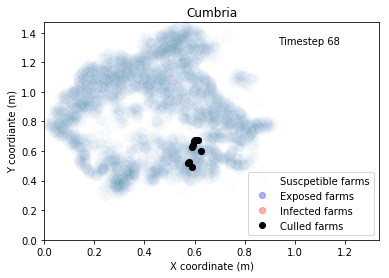

In [20]:
exposed = []
infect = []
culled = []

#appends each day (so that the classes can be colour coordinated)
for i in range(max(InP['Time of Culling'])+1):
    exposed.append(InP[InP['Time of Exposure'] <= i])
    infect.append(InP[InP['Time of Infection']<=i])
    culled.append(InP[InP['Time of Culling']<=i])

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
# All suscpetible farms initally
ax = plt.axes(xlim=(min(xcoord), max(xcoord)), 
              ylim=(min(ycoord), max(ycoord)))
ax.plot(xcoord, ycoord, 'o', alpha=.01, ms=10, label = 'Suscpetible farms')
line1, = ax.plot([], [], 'o', color = 'b', alpha = 0.3, label = 'Exposed farms')
line2,  = ax.plot([], [], 'o', color = 'r', alpha = 0.3, label = 'Infected farms')
line3,  = ax.plot([], [], 'o', color = 'k', alpha = 1, label = 'Culled farms')
time_text = ax.text(0.7, 0.9, '', transform=ax.transAxes)

# initialization function: plot the background of each frame
def init():
    line1.set_data([], [])
    line2.set_data([],[])
    line3.set_data([],[])
    time_text.set_text('')
    return line1, line2, line3,

# animation function of dataframes' list
def animate(i):
    line1.set_data(exposed[i]['X coordinate'], exposed[i]['Y coordinate'])
    line2.set_data(infect[i]['X coordinate'], infect[i]['Y coordinate'])
    line3.set_data(culled[i]['X coordinate'], culled[i]['Y coordinate'])
    time_text.set_text('Timestep {}'.format(i+1))
    return line1, line2, line3, time_text

# call the animator, frames*(1/fps) is the speed of the animation.
# set number of frames to the length of your list of dataframes
anim = animation.FuncAnimation(fig, animate, frames=len(culled), init_func=init, interval=20, blit=True)
plt.legend(loc = 'lower right')
plt.title('Cumbria')
plt.xlabel('X coordinate (m)')
plt.ylabel('Y coordiante (m)')
anim.save('FMD.mp4', fps=1.5)

In [98]:
num_infect = []
for k in infect:
    num_infect.append(len(k))
num_culled = []
for j in culled:
    num_culled.append(len(j))
num_exposed = []
for z in exposed:
    num_exposed.append(len(z))


In [1]:
B = [a_i - b_i for a_i, b_i in zip(num_infect, num_culled)]
Z = [a_i - b_i for a_i, b_i in zip(num_exposed, num_infect)]

NameError: name 'num_infect' is not defined

Text(0,0.5,'percentage of farms')

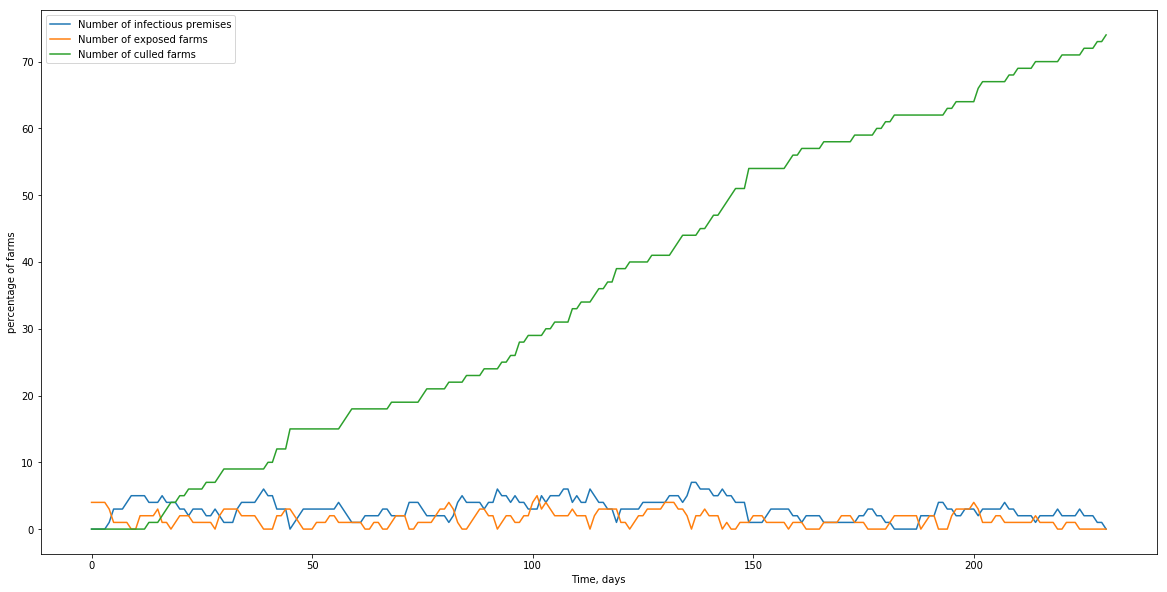

In [113]:
plt.figure(figsize = (20,10))
plt.plot(range(len(culled)), B, label = 'Number of infectious premises')
plt.plot(range(len(culled)), Z, label = 'Number of exposed farms')
plt.plot(range(len(culled)), num_culled, label = 'Number of culled farms')
plt.legend(loc = 'upper left')
plt.xlabel('Time, days')
plt.ylabel('percentage of farms')